In [1]:
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from typing import TypedDict, Annotated
from pydantic import BaseModel, Field
from dotenv import load_dotenv 
import os
import operator


In [2]:
load_dotenv()

True

In [3]:
model = ChatGoogleGenerativeAI(model="gemini-2.5-flash",google_api_key=os.getenv("GOOGLE_API_KEY"))

In [4]:
class EvaluationSchema(BaseModel):
    feedback :str =  Field(description="This is the feedback")
    score : int = Field(description="This is the score range between (0-10)")

In [5]:
structured_output = model.with_structured_output(EvaluationSchema)

In [14]:
essay = """Learning is a lifelong journey fueled by curiosity, discipline, and purpose. Whether pursuing advanced skills in Python, system design, or machine learning, each small achievement builds confidence and expertise. Sometimes, the process feels slow or filled with setbacks, but consistent effort turns challenges into stepping stones. While aiming for career growth, it is important to celebrate progress, connect with mentors, and embrace new ideas. Networking, sharing knowledge, and asking questions all contribute to a richer experience. Ultimately, progress comes not just from books or courses, but from genuine engagement with real projects and the evolving world around us."""

In [37]:
prompt = f'Give feedback and score it according to this essay {essay}'

In [38]:
op = structured_output.invoke(prompt)

In [28]:
op

EvaluationSchema(feedback='This essay provides an insightful and well-articulated perspective on lifelong learning and career development. It effectively highlights the importance of curiosity, discipline, and practical engagement, while also acknowledging potential setbacks and the value of mentorship and networking. The language is encouraging and the advice is practical.', score=9)

In [28]:
class LLMSate(TypedDict):
    essay : str
    cot_feedback : str
    doa_feedback: str
    language_feedback: str
    individual_score : Annotated[list[int], operator.add]
    overall_feedback: str
    final_score : float

In [33]:
def cot(state: LLMSate):
    #essay input
    essay = state['essay']
    #structured prompt
    prompt = f'Give feedback and score it according clarity of this essay {essay}'
    #invoke
    response = structured_output.invoke(prompt)
    cot_feedback = response.feedback
    cot_score = response.score
    return {"cot_feedback": cot_feedback, "individual_score": [response.score]}


def doa(state: LLMSate):
    essay = state["essay"]

    prompt = f'Give feedback and score it according depth of this essay {essay}'
    response = structured_output.invoke(prompt)
    doa_feedback = response.feedback
    doa_score = response.score
    return {"doa_feedback": doa_feedback, "individual_score": [response.score]}

def language(state: LLMSate):
    essay = state["essay"]

    prompt = f'Give feedback and score it according language and grammar of this essay {essay}'
    response = structured_output.invoke(prompt)
    language_feedback = response.feedback
    language_score = response.score

    return {"language_feedback": language_feedback, "individual_score": [response.score]}

def Final_eval(state: LLMSate):
    summary = f"generate a summarized feedback based on these three feedbacks \n {state['cot_feedback'] , state['doa_feedback'], state['language_feedback']}."
    response = model.invoke(summary).content
    avg_score = sum(state["individual_score"])/len(state["individual_score"])
    return {"overall_feedback": response, "overall_feedback": avg_score}



In [34]:
#graph
graph = StateGraph(LLMSate)
#node
graph.add_node("cot",cot)
graph.add_node("doa",doa)
graph.add_node("language",language)
graph.add_node("Final_eval",Final_eval)


#edges
graph.add_edge(START,"cot")
graph.add_edge(START,"doa")
graph.add_edge(START,"language")
graph.add_edge("cot","Final_eval")
graph.add_edge("doa","Final_eval")
graph.add_edge("language","Final_eval")
graph.add_edge("Final_eval",END)

workflow = graph.compile()

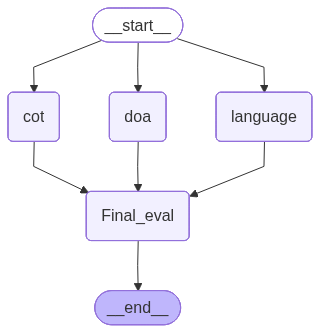

In [35]:
workflow

In [36]:
workflow.invoke({"essay":essay})

{'essay': 'Learning is a lifelong journey fueled by curiosity, discipline, and purpose. Whether pursuing advanced skills in Python, system design, or machine learning, each small achievement builds confidence and expertise. Sometimes, the process feels slow or filled with setbacks, but consistent effort turns challenges into stepping stones. While aiming for career growth, it is important to celebrate progress, connect with mentors, and embrace new ideas. Networking, sharing knowledge, and asking questions all contribute to a richer experience. Ultimately, progress comes not just from books or courses, but from genuine engagement with real projects and the evolving world around us.',
 'cot_feedback': 'The essay demonstrates excellent clarity. The ideas are presented in a straightforward and coherent manner, making it very easy to understand the core message about lifelong learning and continuous improvement. The language is precise, and the flow of thought is logical, ensuring that the